In [1]:
%%time

import os
import numpy as np
import torch
import random
import pytorch_lightning as pl
import cv2
import json

from PIL import Image
from torchvision import transforms
from typing import Dict

from tqdm.notebook import tqdm

import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import CenterCropVideo, NormalizeVideo

from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import ApplyTransformToKey, ShortSideScale, UniformTemporalSubsample, UniformCropVideo

import matplotlib.pyplot as plt
%matplotlib inline

from CPD import datasets, loss, models
from CPD import new_metrics as metrics

CPU times: user 1.41 s, sys: 720 ms, total: 2.13 s
Wall time: 1.39 s


### Fix random seeds

In [2]:
import torch
torch.manual_seed(1)
import random
random.seed(1)
import numpy as np
np.random.seed(1)

### Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataloader

In [4]:
class UCF_VIDEOS_DATASET(torch.utils.data.Dataset):
    def __init__(self, path_to_annotation, path_to_videos, seq_len):
        super(UCF_VIDEOS_DATASET, self).__init__()
        self.path_to_annotation = path_to_annotation
        self.path_to_videos = path_to_videos
        self.seq_len = seq_len
        
        self.annotation_array = []
        
        preprocess = transforms.Compose([transforms.ToTensor()])
        
        time_step = 4
        num_samles = 6
        num_attempts = 300
        
        self.data = []
        self.len = 0
        
        with open(path_to_annotation, 'r') as fp:
            for line in tqdm(fp):
                if line.split("  ")[1] == "Explosion":
                    self.annotation_array.append([line.split("  ")[0], 
                                                  int(line.split("  ")[2]), 
                                                  int(line.split("  ")[3]),
                                                  int(line.split("  ")[4])])
                    
                    cap = cv2.VideoCapture(os.path.join(self.path_to_videos, line.split("  ")[0]))
                    
                    count_ = 0
                    num_attempts_ = 0
                    nums_zeros = []
                    while count_ != num_samles:
                        num_attempts_ += 1
                        num_zeros = random.randint(1, self.seq_len-1)
                        if not num_zeros in nums_zeros:
                            frames_ones = [int(line.split("  ")[3]) + i*time_step for i in range(self.seq_len-num_zeros)]
                            frames_zeros = sorted([int(line.split("  ")[3]) - (i+1)*time_step for i in range(num_zeros)])
                            
                            if frames_zeros[0] >= int(line.split("  ")[2]) and frames_ones[-1] <= int(line.split("  ")[4]):
                                frames_all = np.append(frames_zeros, frames_ones)
                                sequence_labels = np.append(np.zeros(num_zeros), np.ones(self.seq_len-num_zeros))
                                sequence_imgs = []

                                for frame_id in frames_all:
                                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
                                    ret, frame = cap.read()
                                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                                    frame_pil = Image.fromarray(frame_rgb)
                                    sequence_imgs.append(preprocess(frame_pil))

                                sequence_imgs = torch.stack(sequence_imgs)
                                sequence_labels = torch.from_numpy(sequence_labels)
                                self.data.append([sequence_imgs, sequence_labels])

                                count_ += 1
                                nums_zeros.append(num_zeros)
                                self.len += 1
                            
                        if num_attempts_ == num_attempts:
                            break
                            
                if line.split("  ")[1] == "Normal":
                    self.annotation_array.append([line.split("  ")[0], 
                                                  int(line.split("  ")[2]), 
                                                  int(line.split("  ")[4])])
                    
                    cap = cv2.VideoCapture(os.path.join(self.path_to_videos, line.split("  ")[0]))
                    
                    num_zeros = self.seq_len
                    frames_all = sorted([int(line.split("  ")[4]) - i*time_step for i in range(num_zeros)])

                    if frames_zeros[0] >= int(line.split("  ")[2]):
                        sequence_labels = np.zeros(num_zeros)
                        sequence_imgs = []

                        for frame_id in frames_all:
                            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
                            ret, frame = cap.read()
                            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                            frame_pil = Image.fromarray(frame_rgb)
                            sequence_imgs.append(preprocess(frame_pil))

                        sequence_imgs = torch.stack(sequence_imgs)
                        sequence_labels = torch.from_numpy(sequence_labels)
                        self.data.append([sequence_imgs, sequence_labels])
                        self.len += 1
                        
                    frames_all = sorted([int(line.split("  ")[2]) + i*time_step for i in range(num_zeros)])

                    if frames_zeros[-1] <= int(line.split("  ")[5]):
                        sequence_labels = np.zeros(num_zeros)
                        sequence_imgs = []

                        for frame_id in frames_all:
                            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
                            ret, frame = cap.read()
                            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                            frame_pil = Image.fromarray(frame_rgb)
                            sequence_imgs.append(preprocess(frame_pil))

                        sequence_imgs = torch.stack(sequence_imgs)
                        sequence_labels = torch.from_numpy(sequence_labels)
                        self.data.append([sequence_imgs, sequence_labels])
                        self.len += 1

    def __len__(self):
        return self.len
        
    def __getitem__(self, item_idx):
        
        sequence_imgs = self.data[item_idx][0]
        sequence_labels = self.data[item_idx][1]
        
        return sequence_imgs, sequence_labels

In [5]:
%%time

seq_len = 16
path_to_videos = "data/explosion/"
path_annotation_train = "UCF_train.txt"
path_annotation_validation = "UCF_validation.txt"

imgs_dataset_train = UCF_VIDEOS_DATASET(path_annotation_train, 
                                        path_to_videos, 
                                        seq_len=seq_len)

imgs_dataset_validation = UCF_VIDEOS_DATASET(path_annotation_validation, 
                                             path_to_videos, 
                                             seq_len=seq_len)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 11min 3s, sys: 15.2 s, total: 11min 19s
Wall time: 2min 45s


In [6]:
class CPD_model(pl.LightningModule):
    def __init__(
        self,
        model, 
        imgs_dataset_train,
        imgs_dataset_validation,
        batch_size: int = 16,
        seq_len: int = 16, 
        loss_type: str = 'bce',
        path_to_videos: str = "data/explosion/",
        path_annotation_train: str = "UCF_train.txt",
        path_annotation_validation: str = "UCF_validation.txt",
        
    ):
        super(CPD_model, self).__init__()

        self.model = model.to(self.device)
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        if loss_type == 'bce':
            self.loss = nn.BCELoss()
        else:
            self.loss = loss.CPDLoss(len_segment=8)
            
        self.imgs_dataset_train = imgs_dataset_train
        self.imgs_dataset_validation = imgs_dataset_validation   
        
    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        videos, labels = batch
        pred = self.forward(videos.float())

        train_loss = self.loss(pred.squeeze(), labels.float().squeeze())
        train_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()

        self.log('train_loss', train_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', train_accuracy, prog_bar=True, on_epoch=True)    
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        videos, labels = batch
        pred = self.forward(videos.float())
        
        val_loss = self.loss(pred.squeeze(), labels.float().squeeze())      
        val_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()
                
        self.log('val_loss', val_loss, prog_bar=True)    
        self.log('val_acc', val_accuracy, prog_bar=True)    
        
        return {'val_loss': val_loss, 'val_acc': val_accuracy}
    

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=0.001) 
        return [opt]

    def train_dataloader(self):
        
        train_dataloader = DataLoader(self.imgs_dataset_train, batch_size=self.batch_size, 
                                      shuffle=True, num_workers=4)
        return train_dataloader
        
    
    def val_dataloader(self):
        
        val_dataloader = DataLoader(self.imgs_dataset_validation, batch_size=self.batch_size, shuffle=False, num_workers=4)
        return val_dataloader

In [7]:
threshold_number = 25
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

Using cache found in /home/eromanenkova/.cache/torch/hub/facebookresearch_pytorchvideo_main
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 36.9 M
1 | loss  | CPDLoss | 0     
----------------------------------
5.2 M     Trainable params
31.6 M    Non-trainable params
36.9 M    Total params
147.522   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -0.870


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.441 >= min_delta = 0.01. New best score: -1.311


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.347 >= min_delta = 0.01. New best score: -2.658


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.877 >= min_delta = 0.01. New best score: -3.535


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.774 >= min_delta = 0.01. New best score: -4.309


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.066 >= min_delta = 0.01. New best score: -4.375


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.472 >= min_delta = 0.01. New best score: -5.848


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.312 >= min_delta = 0.01. New best score: -6.160


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.606 >= min_delta = 0.01. New best score: -6.766


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.485 >= min_delta = 0.01. New best score: -7.251


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.212 >= min_delta = 0.01. New best score: -7.462


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.123 >= min_delta = 0.01. New best score: -7.585


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.01. New best score: -7.638


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: -7.638. Signaling Trainer to stop.


AUC: 9.466
Time to FA 14.2254, delay detection 1.5434 for best-cover threshold: 0.6027
TP 17, TN 106, FP 19, FN 31 for best-cover threshold: 0.6027
Max COVER 0.8798: for threshold 0.6027
Max F1 0.4598: for threshold 0.6971
F1 0.4048: for best-cover threshold 0.6027
Max F1_ruptures (M=5) 0: for threshold 0.0067
F1_ruptures 0: for best-cover threshold 0.6027


Using cache found in /home/eromanenkova/.cache/torch/hub/facebookresearch_pytorchvideo_main
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 36.9 M
1 | loss  | BCELoss | 0     
----------------------------------
5.2 M     Trainable params
31.6 M    Non-trainable params
36.9 M    Total params
147.522   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.280


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.280. Signaling Trainer to stop.


AUC: 8.5462
Time to FA 14.948, delay detection 1.8092 for best-cover threshold: 0.6971
TP 21, TN 104, FP 5, FN 43 for best-cover threshold: 0.6971
Max COVER 0.8836: for threshold 0.6971
Max F1 0.5439: for threshold 0.3973
F1 0.4667: for best-cover threshold 0.6971
Max F1_ruptures (M=5) 0: for threshold 0.0067
F1_ruptures 0: for best-cover threshold 0.6971


Using cache found in /home/eromanenkova/.cache/torch/hub/facebookresearch_pytorchvideo_main
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 36.9 M
1 | loss  | BCELoss | 0     
----------------------------------
5.2 M     Trainable params
31.6 M    Non-trainable params
36.9 M    Total params
147.522   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.486
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 36.9 M
1 | loss  | CPDLoss | 0     
----------------------------------
5.2 M     Trainable params
31.6 M    Non-trainable params
36.9 M    Total params
147.522   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 2.159 >= min_delta = 0.01. New best score: -1.673


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.116 >= min_delta = 0.01. New best score: -2.789


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.986 >= min_delta = 0.01. New best score: -3.775


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.397 >= min_delta = 0.01. New best score: -4.172


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.441 >= min_delta = 0.01. New best score: -5.613


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.402 >= min_delta = 0.01. New best score: -6.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.584 >= min_delta = 0.01. New best score: -6.599


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.399 >= min_delta = 0.01. New best score: -6.999


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.223 >= min_delta = 0.01. New best score: -7.221


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.589 >= min_delta = 0.01. New best score: -7.810


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.456 >= min_delta = 0.01. New best score: -8.266


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.359 >= min_delta = 0.01. New best score: -8.625


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.084 >= min_delta = 0.01. New best score: -8.709


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: -8.735


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.259 >= min_delta = 0.01. New best score: -8.995


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.01. New best score: -9.046


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.170 >= min_delta = 0.01. New best score: -9.216


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.142 >= min_delta = 0.01. New best score: -9.358


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.368 >= min_delta = 0.01. New best score: -9.726


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: -9.726. Signaling Trainer to stop.


AUC: 7.4701
Time to FA 12.763, delay detection 0.6416 for best-cover threshold: 0.3973
TP 29, TN 96, FP 35, FN 13 for best-cover threshold: 0.3973
Max COVER 0.8955: for threshold 0.3973
Max F1 0.5556: for threshold 0.3029
F1 0.5472: for best-cover threshold 0.3973
Max F1_ruptures (M=5) 0: for threshold 0.0067
F1_ruptures 0: for best-cover threshold 0.3973
32


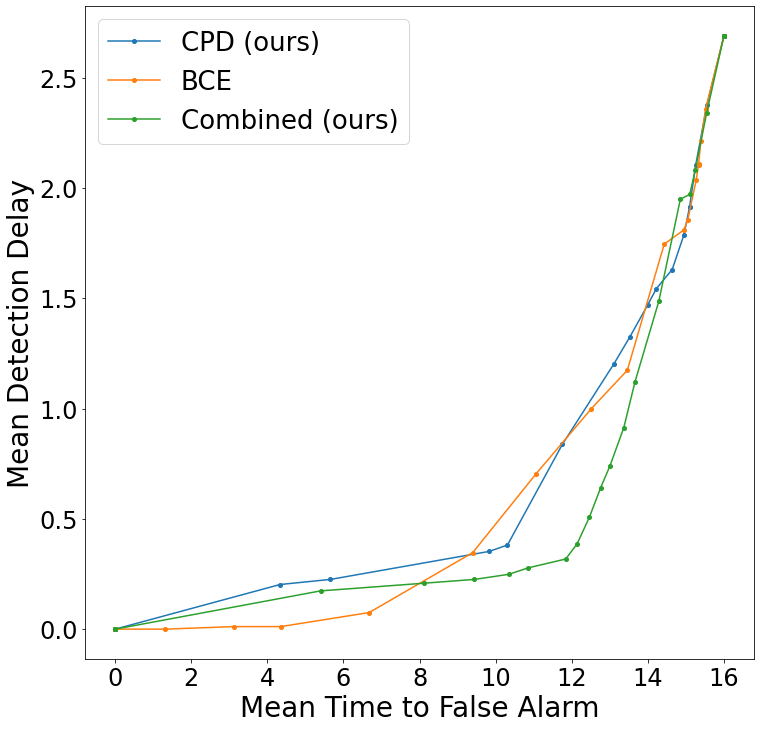

In [8]:
#HIDDEN_LSTM = 16
HIDDEN_LSTM = 2048 * 8 * 10
HIDDEN_SIZE = 16
for HIDDEN_SIZE in [32]:
    class Combine(nn.Module):
        def __init__(self):
            super(Combine, self).__init__()
            # Pick a pretrained model and load the pretrained weights
            model_name = "slow_r50"
            self.extractor = torch.hub.load('facebookresearch/pytorchvideo:main', 'slow_r50', pretrained=True)
            # 5 for full cnn part
            self.extractor = nn.Sequential(*list(self.extractor.blocks[:5]))
            self.fc1 = nn.Linear(HIDDEN_LSTM, HIDDEN_SIZE)
            self.rnn = nn.LSTM(input_size=HIDDEN_SIZE,
                               hidden_size=HIDDEN_SIZE // 2, 
                               num_layers=1,
                               batch_first=True, 
                               dropout=0.5)

            self.fc2 = nn.Linear(HIDDEN_SIZE // 2, 1)
            self.dropout = nn.Dropout(0.5)
            self.relu = nn.ReLU()  
            self.activation = nn.Sigmoid()        

        def forward(self, x):

            batch_size, timesteps, C, H, W = x.size()
            c_in = x.transpose(1, 2) 
            c_out = self.extractor(c_in) # batch_size, timesteps, C*H*W
            r_in = c_out.transpose(1, 2).flatten(2)
            r_out = r_in
            r_out = self.fc1(r_out)
            r_out, _ = self.rnn(r_out)
            r_out = self.dropout(self.fc2(r_out))
            out = torch.sigmoid(r_out)
            return out    


    SEED = 1
    import torch
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(SEED)
    import random
    random.seed(SEED)
    import numpy as np
    np.random.seed(SEED)

    model_custom = Combine()

    for param in model_custom.extractor.parameters():
        param.requires_grad = False

    model_custom_pl = CPD_model(model=model_custom,
                                imgs_dataset_train=imgs_dataset_train,
                                imgs_dataset_validation=imgs_dataset_validation,
                                batch_size=8, 
                                seq_len=16, 
                                loss_type='custom')    



    running = 2

    experiment_name = 'I3D_v{}'.format(running)
    logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='val_acc',
        dirpath=f'logs/{experiment_name}',
        filename='{epoch:02d}-{val_acc:.3f}',
        mode='max')

    checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
        monitor='val_loss',
        dirpath=f'logs/{experiment_name}',
        filename='{epoch:02d}-{val_loss:.3f}',
        mode='min')


    early_stop_callback = EarlyStopping(
       monitor='val_loss',
       min_delta=0.01,
       patience=5,
       verbose=True,
       mode='min'
    )

    trainer_custom = pl.Trainer(
        max_epochs=100, 
        gpus='1', 
        benchmark=True, 
        check_val_every_n_epoch=1, 
        logger=logger,
        callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])    

    trainer_custom.fit(model_custom_pl)

    _, delay_list_cpd, fp_delay_list_cpd = metrics.evaluation_pipeline(model_custom_pl, 
                                                                       model_custom_pl.val_dataloader(), 
                                                                       threshold_list, 
                                                                       device='cuda', 
                                                                       verbose=True)

    np.save('delay_list_cpd_hidden_' + str(HIDDEN_SIZE) + '.npy', delay_list_cpd)
    np.save('fp_delay_list_cpd_hidden_' + str(HIDDEN_SIZE) + '.npy', fp_delay_list_cpd)
    ##########################
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    
    
    model_bce = Combine()

    for param in model_bce.extractor.parameters():
        param.requires_grad = False

    model_bce_pl = CPD_model(model=model_custom,
                                imgs_dataset_train=imgs_dataset_train,
                                imgs_dataset_validation=imgs_dataset_validation,
                                batch_size=8, 
                                seq_len=16, 
                                loss_type='bce')


    experiment_name = 'I3D_v{}'.format(running)
    logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='val_acc',
        dirpath=f'logs/{experiment_name}',
        filename='{epoch:02d}-{val_acc:.3f}',
        mode='max')

    checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
        monitor='val_loss',
        dirpath=f'logs/{experiment_name}',
        filename='{epoch:02d}-{val_loss:.3f}',
        mode='min')


    early_stop_callback = EarlyStopping(
       monitor='val_loss',
       min_delta=0.01,
       patience=5,
       verbose=True,
       mode='min'
    )

    trainer_bce = pl.Trainer(
        max_epochs=100, 
        gpus='1', 
        benchmark=True, 
        check_val_every_n_epoch=1, 
        logger=logger,
        callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])    

    trainer_bce.fit(model_bce_pl)

    _, delay_list_bce, fp_delay_list_bce = metrics.evaluation_pipeline(model_bce_pl, 
                                                                       model_custom_pl.val_dataloader(), 
                                                                       threshold_list, 
                                                                       device='cuda', 
                                                                       verbose=True)

    np.save('delay_list_bce_hidden_' + str(HIDDEN_SIZE) + '.npy', delay_list_bce)
    np.save('fp_delay_list_bce_hidden_' + str(HIDDEN_SIZE) + '.npy', fp_delay_list_bce)

    ################################
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    
    
    model_combined = Combine()

    for param in model_combined.extractor.parameters():
        param.requires_grad = False

    model_combined_pl_1 = CPD_model(model=model_combined,
                                  imgs_dataset_train=imgs_dataset_train,
                                  imgs_dataset_validation=imgs_dataset_validation,
                                  batch_size=8, 
                                  seq_len=16, 
                                  loss_type='bce')

    model_combined_pl_2 = CPD_model(model=model_combined,
                                  imgs_dataset_train=imgs_dataset_train,
                                  imgs_dataset_validation=imgs_dataset_validation,
                                  batch_size=8, 
                                  seq_len=16, 
                                  loss_type='custom')




    running = 2

    experiment_name = 'I3D_v{}'.format(running)
    logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='val_acc',
        dirpath=f'logs/{experiment_name}',
        filename='{epoch:02d}-{val_acc:.3f}',
        mode='max')

    checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
        monitor='val_loss',
        dirpath=f'logs/{experiment_name}',
        filename='{epoch:02d}-{val_loss:.3f}',
        mode='min')


    early_stop_callback = EarlyStopping(
       monitor='val_loss',
       min_delta=0.01,
       patience=5,
       verbose=True,
       mode='min'
    )

    trainer_combined_1 = pl.Trainer(
        max_epochs=1, 
        gpus='1', 
        benchmark=True, 
        check_val_every_n_epoch=1, 
        logger=logger,
        callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])   

    trainer_combined_2 = pl.Trainer(
        max_epochs=100, 
        gpus='1', 
        benchmark=True, 
        check_val_every_n_epoch=1, 
        logger=logger,
        callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])   

    trainer_combined_1.fit(model_combined_pl_1)
    trainer_combined_2.fit(model_combined_pl_2)

    _, delay_list_combined, fp_delay_list_combined = metrics.evaluation_pipeline(model_combined_pl_2, 
                                                                                 model_combined_pl_1.val_dataloader(), 
                                                                                 threshold_list, 
                                                                                 device='cuda', 
                                                                                 verbose=True)


    np.save('delay_list_comb_hidden_' + str(HIDDEN_SIZE) + '.npy', delay_list_combined)
    np.save('fp_delay_list_comb_hidden_' + str(HIDDEN_SIZE) + '.npy', fp_delay_list_combined)

    print(HIDDEN_SIZE)
    plt.figure(figsize=(12, 12))
    plt.plot(fp_delay_list_cpd, delay_list_cpd, '-o', markersize=4, label='CPD (ours)')
    plt.plot(fp_delay_list_bce, delay_list_bce, '-o', markersize=4, label='BCE')
    plt.plot(fp_delay_list_combined, delay_list_combined, '-o', markersize=4, label='Combined (ours)')

    plt.xlabel('Mean Time to False Alarm', fontsize=28)
    plt.ylabel('Mean Detection Delay', fontsize=28)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(loc='upper left', fontsize=26);